In [91]:
import Pkg
Pkg.activate(@__DIR__)
# Pkg.add("Altro")
# Pkg.add("RobotDynamics")
# Pkg.add("TrajectoryOptimization")
# Pkg.instantiate()

# import MathOptInterface as MOI
# import Ipopt 
# import ForwardDiff as FD 
# import Convex as cvx 
# import ECOS
# using LinearAlgebra
# using Plots
# using Random
# using JLD2
# using Test
# import MeshCat as mc 
# using Printf

  Activating project at `~/Documents/CMU-16-745/originals/HW3_S23`


In [1]:
include(joinpath(@__DIR__, "utils","quadrotor.jl"))

function discrete_dynamics(params::NamedTuple, x::Vector, u, k)
    return rk4(params.model, quadrotor_dynamics, x, u, params.model.dt)
end

function create_reference(N, dt)
    # create reference trajectory for quadrotor 
    R = 6
    Xref = [ [R*cos(t);R*cos(t)*sin(t);1.2 + sin(t);zeros(9)] for t = range(-pi/2,3*pi/2, length = N)]
    for i = 1:(N-1)
        Xref[i][4:6] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
    end
    Xref[N][4:6] = Xref[N-1][4:6]
    Uref = [(9.81*0.5/4)*ones(4) for i = 1:(N-1)]
    return Xref, Uref
end

create_reference (generic function with 1 method)

In [2]:
using StaticArrays
using RobotDynamics
const RD = RobotDynamics
using LinearAlgebra
using ForwardDiff
using FiniteDiff

# # Define the model
struct QuadRot <: RD.ContinuousDynamics
    mass::Float64
    J::SMatrix{3,3,Float64,9}
    gravity::SVector{3,Float64}
    L::Float64
    kf::Float64
    km::Float64
end

function QuadRot(;
        mass=0.5,
        J=Diagonal(@SVector [0.0023, 0.0023, 0.004]),
        gravity=SVector(0,0,-9.81),
        L=0.1750,
        kf=1.0,
        km=0.0245,
    )
    @assert issymmetric(J)
    QuadRot(mass,J,gravity,L,kf,km)
end

# Dynamics 
# Define the continuous dynamics
function RD.dynamics(model::QuadRot, x, u)
    return quadrotor_dynamics(model, x, u)
end

function dynamics!(model::QuadRot, xdot, x, u)
    xdot .= dynamics(model, x, u)
end

# Dimensions
RD.state_dim(::QuadRot) = 12
RD.control_dim(::QuadRot) = 4



In [71]:
using Altro
using TrajectoryOptimization
using RobotZoo


model = QuadRot()
nx,nu = RD.dims(model)

# Problem size 
dt = 0.05 
tf = 5.0
t_vec = 0:dt:tf 
N = length(t_vec)

# Reference trajectory
Xref, Uref = create_reference(N, dt)
# Convert to matrix form
Xref = mapreduce(permutedims, vcat, Xref)'
Uref = mapreduce(permutedims, vcat, Uref)'

# Define initial and final conditions
x0 = Xref[:,1]
xf  = Xref[:,end]

# Initialization
u0 = SVector{nu}(Uref[:,1])
U0 = [u0 for k=1:N-1]

# Define the cost weights
Q = 1*Diagonal(SVector{nx}([100*ones(3);0.1*ones(3);1.0*ones(3);1.0*ones(3)]))
R = .1*Diagonal(SVector{nu}(ones(nu)))
Qf = 10*Q 

# Objective
stage_costs = Vector{DiagonalCost}()
# Stage costs
for i=1:N-1
    push!(stage_costs, LQRCost(Q, R, Xref[:,i]))
end

obj = Objective(stage_costs, LQRCost(Qf, R, xf))

# obj = LQRObjective(Q,R,Qf,xf,N)

veclocity_bound = 10
x0[4:6] = clamp.(x0[4:6], -veclocity_bound, veclocity_bound)
xf[4:6] = clamp.(xf[4:6], -veclocity_bound, veclocity_bound)

# Constraints
conSet = ConstraintList(nx,nu,N)
x_max=Inf*ones(nx)
x_min=-Inf*ones(nx)
x_max[4:6] .= veclocity_bound
x_min[4:6] .= -veclocity_bound
bounds = BoundConstraint(nx,nu, x_min=x_min, x_max=x_max, u_min=0, u_max=2.5)
# goal = GoalConstraint(xf)
add_constraint!(conSet, bounds, 1:N-1)
# add_constraint!(conSet, goal, N)

# # Define problem
prob = Problem(model, obj, x0, tf, xf=xf, constraints=conSet)
initial_controls!(prob, U0)

# Solve with ALTRO
opts = SolverOptions(
    cost_tolerance_intermediate=1e-2,
    penalty_scaling=2.,
    penalty_initial=1.0
)
altro = ALTROSolver(prob, opts)
solve!(altro)

# Get some info on the solve
max_violation(altro)  # 5.896e-7
cost(altro)           # 1.539
iterations(altro)     # 44

# Extract the solution
X = states(altro)
U = controls(altro)

# Extract the solver statistics
stats = Altro.stats(altro)   # alternatively, solver.stats
stats.iterations             # 44, equivalent to iterations(solver)
stats.iterations_outer       # 4 (number of Augmented Lagrangian iterations)
stats.iterations_pn          # 1 (number of projected newton iterations)
stats.cost[end]              # terminal cost
stats.c_max[end]             # terminal constraint satisfaction
stats.gradient[end]          # terminal gradient of the Lagrangian
dstats = Dict(stats)         # get the per-iteration stats as a dictionary (can be converted to DataFrame)


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 52
    Solve Time: 371.00838999999996 (ms)

  Covergence
    Terminal Cost: 312.65257664110004
    Terminal dJ: 2.120857857335068e-6
    Terminal gradient: 0.00011375861052068033
    Terminal constraint violation: 7.028519988239168e-10
    Solve Status: SOLVE_SUCCEEDED


Dict{Symbol, Vector} with 8 entries:
  :gradient        => [14.1695, 24.4306, 0.235257, 0.0711006, 0.0184912, 0.0070…
  :cost            => [1.66486e6, 603.455, 309.4, 293.629, 292.751, 292.586, 29…
  :iteration_pn    => Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0…
  :iteration       => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  43, 44, 45, 46, 47, 48…
  :c_max           => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0…
  :penalty_max     => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  128…
  :iteration_outer => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  8, 9, 10, 10, 10, 11, 1…
  :dJ              => [4.97223e6, 1.66425e6, 294.055, 15.7706, 0.87812, 0.16479…

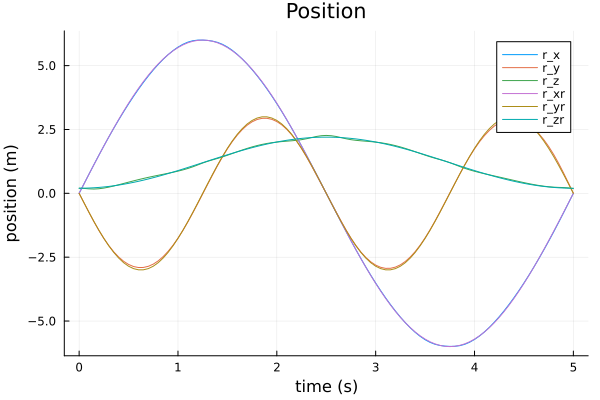

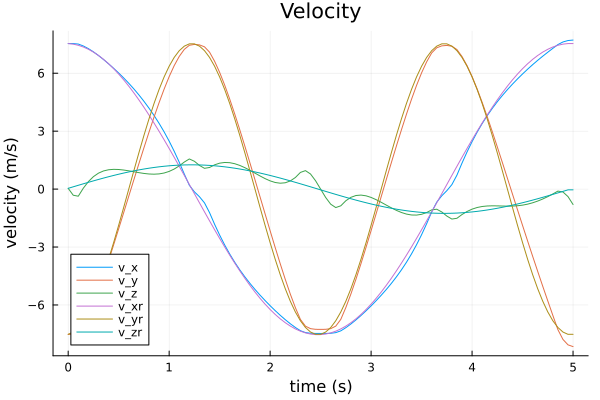

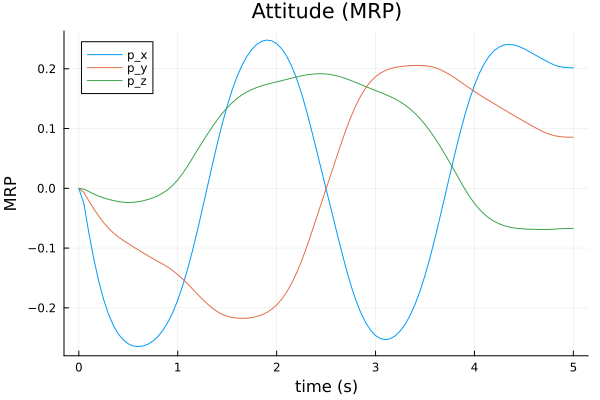

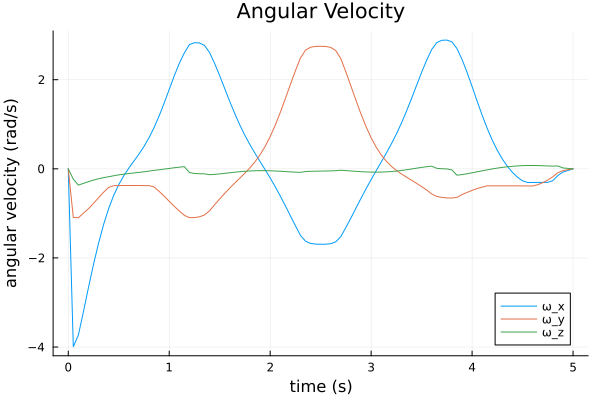

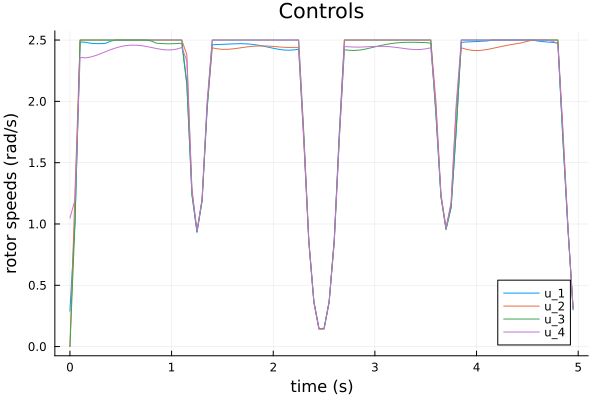

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8713


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("traj" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("p94" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s14" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x31, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s44" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x34, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s52" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x35, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p92" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p98" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x38], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x36], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p23" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x32, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p90" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x30], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s94" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x39, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}())…)), "vic" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x76, 0x69, 0x63], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "target" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x74, 0x2f, 0x74, 0x61, 0x72, 0x67, 0x65, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{Any}(), ip"127.0.0.1", 8713))

In [72]:
using Plots
import MeshCat as mc 
using Printf

# ---------------plotting------------------
Xm = hcat(X...)
Um = hcat(U...)
t_vec = t_vec[1:N]
plot(t_vec, Xm[1:3,:]', xlabel = "time (s)", ylabel = "position (m)",
                               title = "Position", label = ["r_x" "r_y" "r_z"])
display(plot!(t_vec, Xref[1:3,1:N]', xlabel = "time (s)", ylabel = "position (m)",
                               title = "Position", label = ["r_xr" "r_yr" "r_zr"]))
plot(t_vec, Xm[4:6,:]', xlabel = "time (s)", ylabel = "velocity (m/s)",
                               title = "Velocity", label = ["v_x" "v_y" "v_z"])
display(plot!(t_vec, Xref[4:6,1:N]', xlabel = "time (s)", ylabel = "velocity (m/s)",
                               title = "Velocity", label = ["v_xr" "v_yr" "v_zr"]))
display(plot(t_vec, Xm[7:9,:]', xlabel = "time (s)", ylabel = "MRP",
                               title = "Attitude (MRP)", label = ["p_x" "p_y" "p_z"]))
display(plot(t_vec, Xm[10:12,:]', xlabel = "time (s)", ylabel = "angular velocity (rad/s)",
                               title = "Angular Velocity", label = ["ω_x" "ω_y" "ω_z"]))
display(plot(t_vec[1:end-1], Um', xlabel = "time (s)", ylabel = "rotor speeds (rad/s)",
                               title = "Controls", label = ["u_1" "u_2" "u_3" "u_4"]))
display(animate_quadrotor([Xm[:,i] for i=1:N], [Xref[:,i] for i=1:N], dt))

In [145]:
using Altro
using TrajectoryOptimization
using RobotZoo

function altro_mpc(model_mpc, N_MPC, dt, Xh, x0, u0)

    # @show N_MPC
    # @show dt
    # @show x0
    # @show u0
    # display(Xh)

    nx,nu = RD.dims(model)

    tf = N_MPC*dt

    # Define initial and final conditions
    xf  = Xh[:,end]
    
    # Initialization
    U0 = [u0 for k=1:N_MPC-1]
    
    # Define the cost weights
    Q = 1.0*Diagonal(SVector{nx}([100*ones(3);0.01*ones(3);0.00*ones(3);0.00*ones(3)]))
    R = 0.1*Diagonal(SVector{nu}(ones(nu)))
    Qf = 1*Q 
    
    # Objective
    stage_costs = Vector{DiagonalCost}()
    # Stage costs
    for i=1:N_MPC-1
        push!(stage_costs, LQRCost(Q, R, Xh[:,i]))
    end
    
    obj = Objective(stage_costs, LQRCost(Qf, R, xf))
    
    # veclocity_bound = 10
    # x0[4:6] = clamp.(x0[4:6], -veclocity_bound, veclocity_bound)
    # xf[4:6] = clamp.(xf[4:6], -veclocity_bound, veclocity_bound)
    
    # Constraints
    conSet = ConstraintList(nx,nu,N_MPC)
    x_max=Inf*ones(nx)
    x_min=-Inf*ones(nx)
    # x_max[4:6] .= veclocity_bound
    # x_min[4:6] .= -veclocity_bound
    bounds = BoundConstraint(nx,nu, x_min=x_min, x_max=x_max, u_min=0, u_max=5)
    # goal = GoalConstraint(xf)
    add_constraint!(conSet, bounds, 1:N_MPC-1)
    # add_constraint!(conSet, goal, N_MPC)
    
    # # Define problem
    prob = Problem(model_mpc, obj, x0, tf, xf=xf, constraints=conSet)
    initial_controls!(prob, U0)
    
    # Solve with ALTRO
    opts = SolverOptions(
        cost_tolerance_intermediate=1e-2,
        penalty_scaling=1.1,
        penalty_initial=1.0
    )
    altro = ALTROSolver(prob, verbose=true,opts)
    solve!(altro)
    
    # Get some info on the solve
    # max_violation(altro)  # 5.896e-7
    # cost(altro)           # 1.539
    # iterations(altro)     # 44
    
    # Extract the solution
    # X = states(altro)
    U = controls(altro)

    # Get some info on the solve
    max_violation(altro)  # 5.896e-7
    cost(altro)           # 1.539
    iterations(altro)     # 44
    
    # Extract the solution
    X = states(altro)
    U = controls(altro)
    
    # Extract the solver statistics
    # stats = Altro.stats(altro)   # alternatively, solver.stats
    # stats.iterations             # 44, equivalent to iterations(solver)
    # stats.iterations_outer       # 4 (number of Augmented Lagrangian iterations)
    # stats.iterations_pn          # 1 (number of projected newton iterations)
    # stats.cost[end]              # terminal cost
    # stats.c_max[end]             # terminal constraint satisfaction
    # stats.gradient[end]          # terminal gradient of the Lagrangian
    # @show dstats = Dict(stats)         # get the per-ite

    # @show U[1]
    
    return U[1]
    
end




model = QuadRot()
nx,nu = RD.dims(model)

# Problem size 
dt = 0.05 
tf = 5.0
t_vec = 0:dt:tf 
N = length(t_vec)
N_MPC = 10

# Reference trajectory
Xref, Uref = create_reference(N, dt)
# Convert to matrix form
Xref = mapreduce(permutedims, vcat, Xref)'
Uref = mapreduce(permutedims, vcat, Uref)'

# real model parameters for dynamics 
model_real = (mass=0.5,
        J=Diagonal([0.0025, 0.002, 0.0045]),
        gravity=[0,0,-9.81],
        L=0.1550,
        kf=0.9,
        km=0.0365)

# simulate closed loop system 
Xsim = [zeros(nx) for i = 1:N]
Usim = [zeros(nu) for i = 1:(N-1)]

# initial condition 
# Xref[4:6,1] .= 2
Xsim[1] = Xref[:,1]
Usim[1] = Uref[:,1]

# Extend the reference trajectory and zero the velocities
Xref = hcat(Xref, repeat(Xref[:,end], 1, N_MPC))
Uref = hcat(Uref, repeat(Uref[:,end], 1, N_MPC))

# TODO: simulate with closed loop control 
for i = 1:N-1
    Usim[i] = altro_mpc(model, N_MPC, dt, copy(Xref[:,i:i+N_MPC]), copy(Xsim[i]), copy(Uref[:,1]))
    Xsim[i+1] = rk4(model_real, quadrotor_dynamics, Xsim[i], Usim[i], dt)
end

Xsim[1] = [3.6739403974420594e-16, -3.6739403974420594e-16, 0.19999999999999996, 7.534862343517615, -7.519994013858265, 0.03946543143456882, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 21
    Solve Time: 24.055487 (ms)

  Covergence
    Terminal Cost: 9.417168661145418
    Terminal dJ: 0.002230778177723991
    Terminal gradient: 0.022523106975434144
    Terminal constraint violation: 0.0
    Solve Status: SOLVE_SUCCEEDED

SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 1000
    Solve Time: 2344.66758 (ms)

  Covergence
    Terminal Cost: 30.495853385486313
    Terminal dJ: 0.00014486533937230206
    Terminal gradient: 1.0226335321351945
    Terminal constraint violation: 0

LoadError: InexactError: trunc(UInt8, 297)

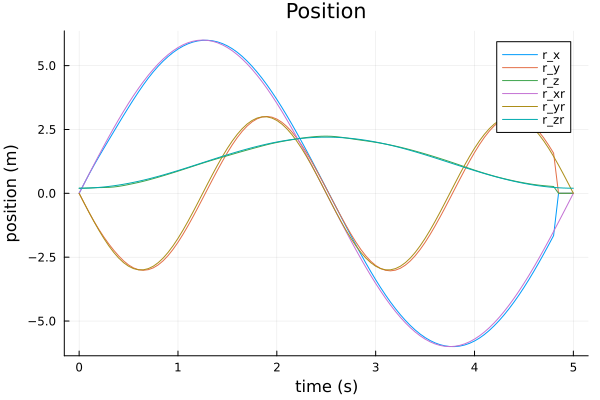

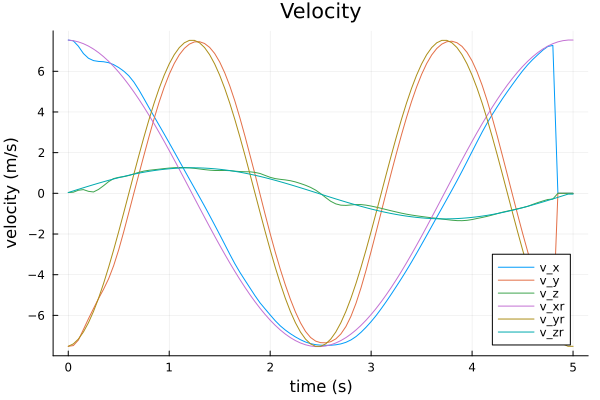

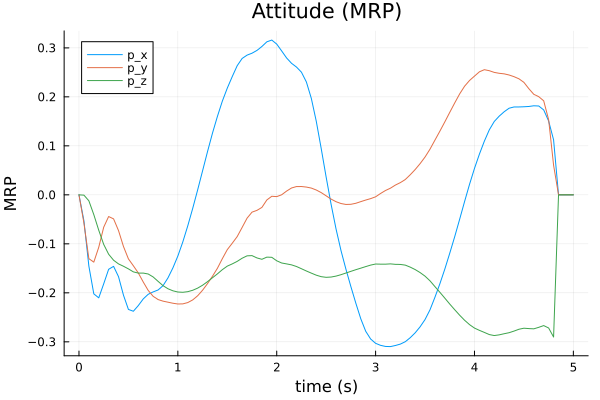

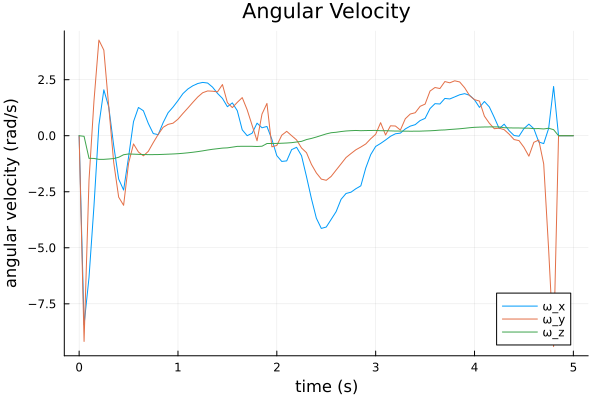

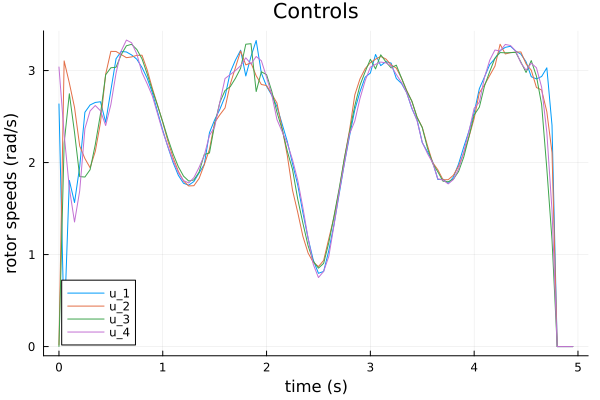

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8719


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("traj" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("p94" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s14" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x31, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s44" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x34, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s52" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x35, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p92" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p98" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x38], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x36], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p23" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x32, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p90" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x30], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s94" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x39, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}())…)), "vic" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x76, 0x69, 0x63], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "target" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x74, 0x2f, 0x74, 0x61, 0x72, 0x67, 0x65, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{Any}(), ip"127.0.0.1", 8719))

In [144]:
using Plots
import MeshCat as mc 
using Printf

Xm = hcat(Xsim...)
Um = hcat(Usim...)

plot(t_vec, Xm[1:3,:]', xlabel = "time (s)", ylabel = "position (m)",
                               title = "Position", label = ["r_x" "r_y" "r_z"])
display(plot!(t_vec, Xref[1:3,1:N]', xlabel = "time (s)", ylabel = "position (m)",
                               title = "Position", label = ["r_xr" "r_yr" "r_zr"]))
plot(t_vec, Xm[4:6,:]', xlabel = "time (s)", ylabel = "velocity (m/s)",
                               title = "Velocity", label = ["v_x" "v_y" "v_z"])
display(plot!(t_vec, Xref[4:6,1:N]', xlabel = "time (s)", ylabel = "velocity (m/s)",
                               title = "Velocity", label = ["v_xr" "v_yr" "v_zr"]))
display(plot(t_vec, Xm[7:9,:]', xlabel = "time (s)", ylabel = "MRP",
                               title = "Attitude (MRP)", label = ["p_x" "p_y" "p_z"]))
display(plot(t_vec, Xm[10:12,:]', xlabel = "time (s)", ylabel = "angular velocity (rad/s)",
                               title = "Angular Velocity", label = ["ω_x" "ω_y" "ω_z"]))
display(plot(t_vec[1:end-1], Um', xlabel = "time (s)", ylabel = "rotor speeds (rad/s)",
                               title = "Controls", label = ["u_1" "u_2" "u_3" "u_4"]))
display(animate_quadrotor([Xm[:,i] for i=1:N], [Xref[:,i] for i=1:N], dt))